In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import cv2
import imblearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
%matplotlib inline

In [3]:
curr_dir = os.getcwd()
path = os.path.dirname(curr_dir)
print(path)
csv_file_path = os.path.join(path, 'DataCSV/MixFall_2Dfrom3D.csv')

/home/rasho/Falling-Person-Detection-based-On-AlphaPose/dataset


In [4]:
df = pd.read_csv(csv_file_path)
df = df.drop(['Unnamed: 0','image_id','box'], axis=1)
#df = df.sort_values(['score'],ascending=False)

In [5]:
df.head()

,pos_class,score,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,RFoot_x,RFoot_y,...,LElbow_x,LElbow_y,LWrist_x,LWrist_y,RShoulder_x,RShoulder_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y
0,Fall,2.473748,474.981901,610.583844,493.648619,613.104132,493.336713,672.790072,472.686687,737.260225,...,375.391247,510.030532,321.319963,518.462343,484.498779,507.149329,528.162741,514.583303,546.046551,476.897151
1,Fall,2.418112,474.981901,610.583844,490.494479,608.015260,495.309058,665.818495,480.670790,735.973402,...,362.851871,515.830660,319.068150,516.647192,471.236790,509.908708,507.589407,504.644312,521.697357,465.813094
2,Fall,2.625777,474.981901,610.583844,477.826457,615.215112,491.872619,668.848957,479.209759,735.607435,...,477.350071,492.454057,512.705099,468.277078,433.582157,517.222083,375.913521,547.543786,332.611525,569.911805
3,Fall,2.519368,474.981901,610.583844,480.606018,616.563539,503.624800,678.002263,492.481647,741.879692,...,472.025412,479.363713,493.735795,460.230922,457.574476,527.524570,489.571035,517.303772,521.364185,482.958045
4,Fall,2.612864,474.981901,610.583844,492.112566,610.211542,486.382273,655.848164,484.479213,713.642151,...,332.538391,523.263048,295.717117,534.001441,460.328543,512.344423,492.477188,490.353638,493.898414,466.745396


In [117]:
cols = df.columns[2:]

In [121]:
cols

Index(['Hip_x', 'Hip_y', 'RHip_x', 'RHip_y', 'RKnee_x', 'RKnee_y', 'RFoot_x',
       'RFoot_y', 'LHip_x', 'LHip_y', 'LKnee_x', 'LKnee_y', 'LFoot_x',
       'LFoot_y', 'Spine_x', 'Spine_y', 'Thorax_x', 'Thorax_y', 'Nose_x',
       'Nose_y', 'Head_x', 'Head_y', 'LShoulder_x', 'LShoulder_y', 'LElbow_x',
       'LElbow_y', 'LWrist_x', 'LWrist_y', 'RShoulder_x', 'RShoulder_y',
       'RElbow_x', 'RElbow_y', 'RWrist_x', 'RWrist_y'],
      dtype='object')

In [122]:
for idx, value in enumerate(cols):
    print(idx,value)

0 Hip_x
1 Hip_y
2 RHip_x
3 RHip_y
4 RKnee_x
5 RKnee_y
6 RFoot_x
7 RFoot_y
8 LHip_x
9 LHip_y
10 LKnee_x
11 LKnee_y
12 LFoot_x
13 LFoot_y
14 Spine_x
15 Spine_y
16 Thorax_x
17 Thorax_y
18 Nose_x
19 Nose_y
20 Head_x
21 Head_y
22 LShoulder_x
23 LShoulder_y
24 LElbow_x
25 LElbow_y
26 LWrist_x
27 LWrist_y
28 RShoulder_x
29 RShoulder_y
30 RElbow_x
31 RElbow_y
32 RWrist_x
33 RWrist_y


In [123]:
index = [0,1,2,3,4,5,8,9,10,11,14,15,16,17,24,25,26,27,30,31,32,33]
for idx in index:
    print(cols[idx])

Hip_x
Hip_y
RHip_x
RHip_y
RKnee_x
RKnee_y
LHip_x
LHip_y
LKnee_x
LKnee_y
Spine_x
Spine_y
Thorax_x
Thorax_y
LElbow_x
LElbow_y
LWrist_x
LWrist_y
RElbow_x
RElbow_y
RWrist_x
RWrist_y


In [124]:
cols[index]

Index(['Hip_x', 'Hip_y', 'RHip_x', 'RHip_y', 'RKnee_x', 'RKnee_y', 'LHip_x',
       'LHip_y', 'LKnee_x', 'LKnee_y', 'Spine_x', 'Spine_y', 'Thorax_x',
       'Thorax_y', 'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y', 'RElbow_x',
       'RElbow_y', 'RWrist_x', 'RWrist_y'],
      dtype='object')

In [7]:
df.iloc[:,0]

0           Fall
1           Fall
2           Fall
3           Fall
4           Fall
           ...  
105911    Nofall
105912    Nofall
105913    Nofall
105914    Nofall
105915    Nofall
Name: pos_class, Length: 105916, dtype: object

In [8]:
def normalize_min_(pose:np.ndarray):
    print(pose.shape)
    pose = pose.reshape(len(pose),-1,2)
    for i in range(len(pose)):
        xmin = np.min(pose[i,:,0]) 
        ymin = np.min(pose[i,:,1])
        xlen = np.max(pose[i,:,0]) - xmin
        ylen = np.max(pose[i,:,1]) - ymin

        if(xlen==0): pose[i,:,0]=0
        else:
            pose[i,:,0] -= xmin 
            pose[i,:,0] /= xlen

        if(ylen==0): pose[i,:,1]=0
        else:
            pose[i,:,1] -= ymin
            pose[i,:,1] /= ylen
    return pose

In [9]:
features = df.iloc[:,2:].values
#return values of pose_class 
pose_class = df['pos_class'].values
# normalize keypoints 
features = normalize_min_(features)
features = features.reshape(-1,34)

(105916, 34)


In [11]:
df2 = pd.DataFrame(features, columns=['Hip_x', 'Hip_y', 'RHip_x', 'RHip_y', 'RKnee_x', 'RKnee_y',
       'RFoot_x', 'RFoot_y', 'LHip_x', 'LHip_y', 'LKnee_x', 'LKnee_y',
       'LFoot_x', 'LFoot_y', 'Spine_x', 'Spine_y', 'Thorax_x', 'Thorax_y',
       'Nose_x', 'Nose_y', 'Head_x', 'Head_y', 'LShoulder_x', 'LShoulder_y',
       'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y', 'RShoulder_x',
       'RShoulder_y', 'RElbow_x', 'RElbow_y', 'RWrist_x', 'RWrist_y'])

In [12]:
df2['pos_class'] = df['pos_class'].values
df2['score'] = df['score'].values

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105916 entries, 0 to 105915
Data columns (total 36 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Hip_x        105916 non-null  float64
 1   Hip_y        105916 non-null  float64
 2   RHip_x       105916 non-null  float64
 3   RHip_y       105916 non-null  float64
 4   RKnee_x      105916 non-null  float64
 5   RKnee_y      105916 non-null  float64
 6   RFoot_x      105916 non-null  float64
 7   RFoot_y      105916 non-null  float64
 8   LHip_x       105916 non-null  float64
 9   LHip_y       105916 non-null  float64
 10  LKnee_x      105916 non-null  float64
 11  LKnee_y      105916 non-null  float64
 12  LFoot_x      105916 non-null  float64
 13  LFoot_y      105916 non-null  float64
 14  Spine_x      105916 non-null  float64
 15  Spine_y      105916 non-null  float64
 16  Thorax_x     105916 non-null  float64
 17  Thorax_y     105916 non-null  float64
 18  Nose_x       105916 non-

In [58]:
df2[['Spine_x','Spine_y','score']].describe()

,Spine_x,Spine_y,score
count,105916.000000,105916.000000,105916.000000
mean,0.566481,0.385306,2.484646
std,0.178635,0.139687,0.581239
min,0.000000,0.000000,0.548282
25%,0.431208,0.299715,2.194285
50%,0.595370,0.357630,2.721202
75%,0.705647,0.446881,2.917251
max,1.000000,1.000000,3.183416


The std measures how dispersed the values are from the mean. The 25% (first quartile), 50% (median), 75% (third quartile) rows show the correspondig percentiles.

In [17]:
df2[['pos_class','score']].value_counts()

pos_class  score   
Fall       2.940467    10
           3.002528     9
           3.014074     9
           2.932222     9
           3.004613     9
                       ..
Nofall     2.185694     1
           2.185708     1
           2.185837     1
           2.185875     1
Fall       0.548282     1
Length: 104884, dtype: int64

In [ ]:
df2.hist(bins=35, figsize=(20,35))
plt.show()

In [18]:
label_encoder = LabelEncoder()
df2['pos_class'] = label_encoder.fit_transform(df2['pos_class']).astype('float64')

In [19]:
df2.head()

,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,RFoot_x,RFoot_y,LHip_x,LHip_y,...,LWrist_x,LWrist_y,RShoulder_x,RShoulder_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,pos_class,score
0,0.683773,0.542320,0.766837,0.551426,0.765449,0.767070,0.673559,1.0,0.602313,0.533233,...,0.000000,0.209486,0.726122,0.168613,0.920420,0.195471,1.0,0.059312,0.0,2.473748
1,0.769453,0.535870,0.846010,0.526362,0.869771,0.740321,0.797529,1.0,0.693623,0.545222,...,0.000000,0.188163,0.750971,0.163220,0.930376,0.143734,1.0,0.000000,0.0,2.418112
2,0.790536,0.532325,0.806330,0.549650,0.884324,0.750277,0.814011,1.0,0.775145,0.515518,...,1.000000,0.000000,0.560656,0.183088,0.240442,0.296512,0.0,0.380184,0.0,2.625777
3,0.299634,0.533831,0.384557,0.555062,0.732138,0.773202,0.563878,1.0,0.218065,0.513096,...,0.582815,0.000000,0.036784,0.238928,0.519928,0.202638,1.0,0.080693,0.0,2.519368
4,0.904549,0.582585,0.990989,0.581077,0.962074,0.765918,0.952472,1.0,0.820142,0.583897,...,0.000000,0.272406,0.830610,0.184689,0.992829,0.095620,1.0,0.000000,0.0,2.612864


In [30]:
corr_matrix = df2.corr()

In [31]:
corr_matrix['pos_class'].sort_values(ascending=False)

pos_class      1.000000
Hip_y          0.336563
LHip_y         0.308798
RHip_y         0.277171
LKnee_y        0.241532
Hip_x          0.229174
LHip_x         0.219047
Spine_y        0.172545
RKnee_y        0.172534
RHip_x         0.169254
LWrist_x       0.161079
RWrist_y       0.152793
Spine_x        0.132729
LKnee_x        0.122669
LFoot_y        0.104372
RElbow_y       0.086606
LElbow_x       0.084363
RFoot_y        0.067630
LShoulder_x    0.066492
Nose_x         0.066390
LWrist_y       0.047308
RElbow_x       0.040194
Thorax_x       0.038836
RWrist_x       0.036744
score          0.033836
LElbow_y       0.032520
RShoulder_x    0.012025
Head_x        -0.001019
RKnee_x       -0.002713
RShoulder_y   -0.002865
LFoot_x       -0.018524
Thorax_y      -0.025382
LShoulder_y   -0.027799
Nose_y        -0.070122
RFoot_x       -0.077283
Head_y        -0.101531
Name: pos_class, dtype: float64

In [35]:
df3 = df2.drop(['LShoulder_y','LShoulder_x','RShoulder_x','RShoulder_y','RFoot_y','LFoot_y','RFoot_x','LFoot_x','Nose_y','Nose_x','Head_x','Head_y'],axis=1)

In [36]:
df3

,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,LHip_x,LHip_y,LKnee_x,LKnee_y,...,LElbow_x,LElbow_y,LWrist_x,LWrist_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,pos_class,score
0,0.683773,0.542320,0.766837,0.551426,0.765449,0.767070,0.602313,0.533233,0.709210,0.733625,...,0.240609,0.179022,0.000000,0.209486,0.920420,0.195471,1.0,0.059312,0.0,2.473748
1,0.769453,0.535870,0.846010,0.526362,0.869771,0.740321,0.693623,0.545222,0.824317,0.748223,...,0.216078,0.185140,0.000000,0.188163,0.930376,0.143734,1.0,0.000000,0.0,2.418112
2,0.790536,0.532325,0.806330,0.549650,0.884324,0.750277,0.775145,0.515518,0.961910,0.765468,...,0.803685,0.090439,1.000000,0.000000,0.240442,0.296512,0.0,0.380184,0.0,2.625777
3,0.299634,0.533831,0.384557,0.555062,0.732138,0.773202,0.218065,0.513096,0.789500,0.765931,...,0.254991,0.067931,0.582815,0.000000,0.519928,0.202638,1.0,0.080693,0.0,2.519368
4,0.904549,0.582585,0.990989,0.581077,0.962074,0.765918,0.820142,0.583897,0.957808,0.755543,...,0.185796,0.228912,0.000000,0.272406,0.992829,0.095620,1.0,0.000000,0.0,2.612864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105911,0.467801,0.563755,0.599900,0.589800,0.326467,0.797378,0.334721,0.537717,0.435395,0.695022,...,0.252408,0.296927,0.280644,0.351329,0.895053,0.531157,1.0,0.601242,1.0,2.798440
105912,0.520970,0.586050,0.635176,0.608361,0.318137,0.818399,0.405527,0.563661,0.466687,0.776107,...,0.321983,0.303244,0.279130,0.422085,0.866164,0.529728,1.0,0.600573,1.0,2.808783
105913,0.500961,0.574789,0.619819,0.593548,0.331785,0.806958,0.381062,0.556006,0.457889,0.726885,...,0.317157,0.320912,0.233447,0.426222,0.870148,0.530043,1.0,0.597243,1.0,2.803776
105914,0.508523,0.562977,0.627892,0.586683,0.340410,0.798450,0.387897,0.539206,0.470985,0.732834,...,0.306453,0.277783,0.262816,0.395944,0.881182,0.524324,1.0,0.601011,1.0,2.712823


In [37]:
corr2_matrix = df3.corr()

In [38]:
corr2_matrix['pos_class'].sort_values(ascending=False)

pos_class    1.000000
Hip_y        0.336563
LHip_y       0.308798
RHip_y       0.277171
LKnee_y      0.241532
Hip_x        0.229174
LHip_x       0.219047
Spine_y      0.172545
RKnee_y      0.172534
RHip_x       0.169254
LWrist_x     0.161079
RWrist_y     0.152793
Spine_x      0.132729
LKnee_x      0.122669
RElbow_y     0.086606
LElbow_x     0.084363
LWrist_y     0.047308
RElbow_x     0.040194
Thorax_x     0.038836
RWrist_x     0.036744
score        0.033836
LElbow_y     0.032520
RKnee_x     -0.002713
Thorax_y    -0.025382
Name: pos_class, dtype: float64

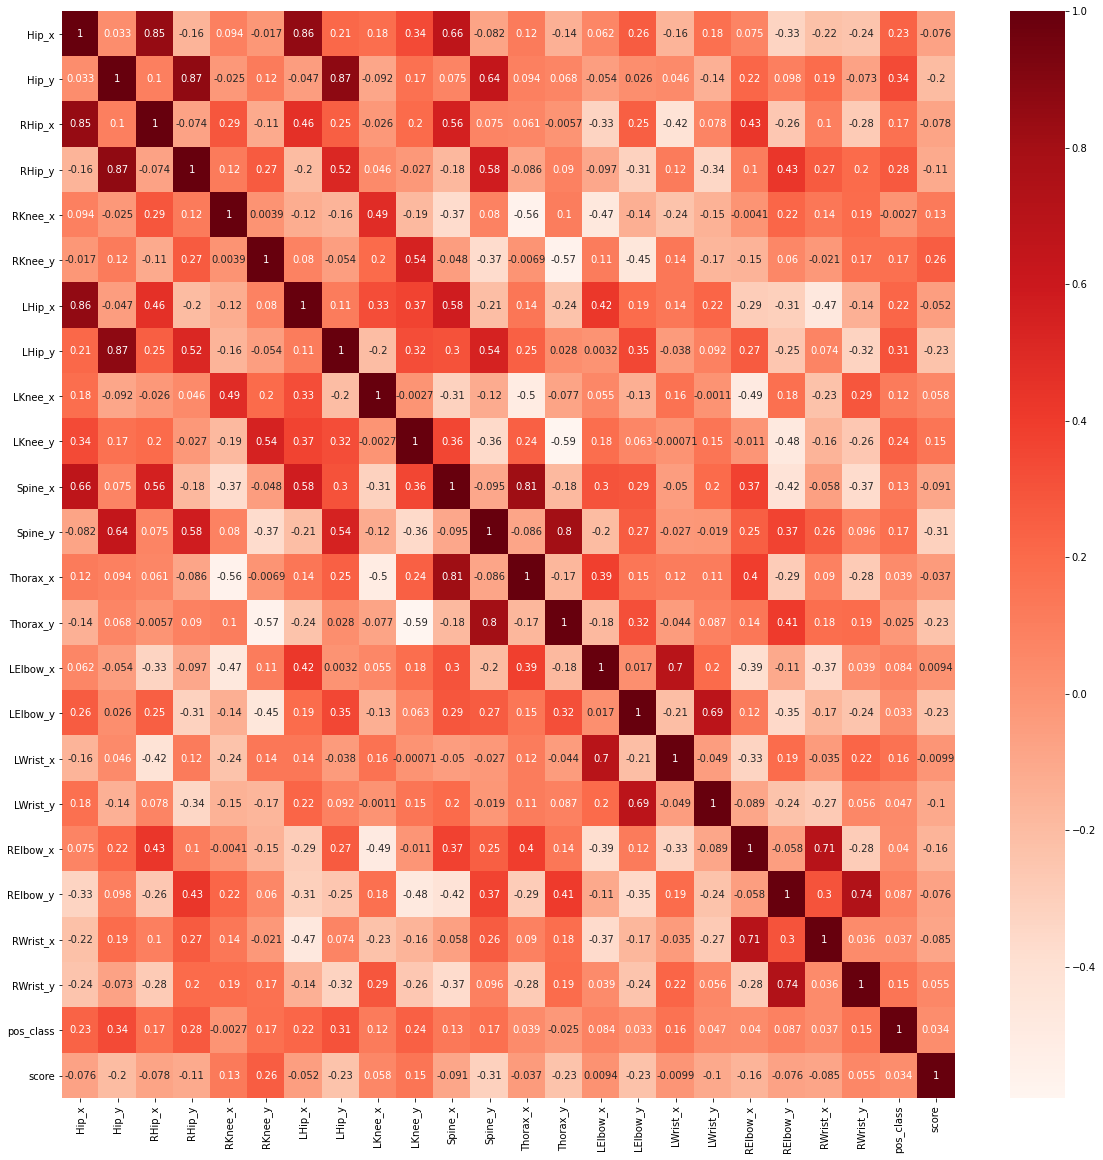

In [40]:
fig = plt.figure(figsize = (20, 20))
_=sns.heatmap(corr2_matrix,annot=True, cmap=plt.cm.Reds)
plt.savefig(os.path.dirname(csv_file_path)+'/pearson_corr.jpg')

In [41]:
columns = np.full((corr2_matrix.shape[0],), True, dtype=bool)
for i in range(corr2_matrix.shape[0]):
    for j in range(i+1, corr2_matrix.shape[0]):
        if corr2_matrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [42]:
selected_columns = df3.columns[columns]

In [43]:
selected_columns

Index(['Hip_x', 'Hip_y', 'RHip_x', 'RHip_y', 'RKnee_x', 'RKnee_y', 'LHip_x',
       'LHip_y', 'LKnee_x', 'LKnee_y', 'Spine_x', 'Spine_y', 'Thorax_x',
       'Thorax_y', 'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y', 'RElbow_x',
       'RElbow_y', 'RWrist_x', 'RWrist_y', 'pos_class', 'score'],
      dtype='object')

In [ ]:
df2 = df[selected_columns]

In [ ]:
df2.head()

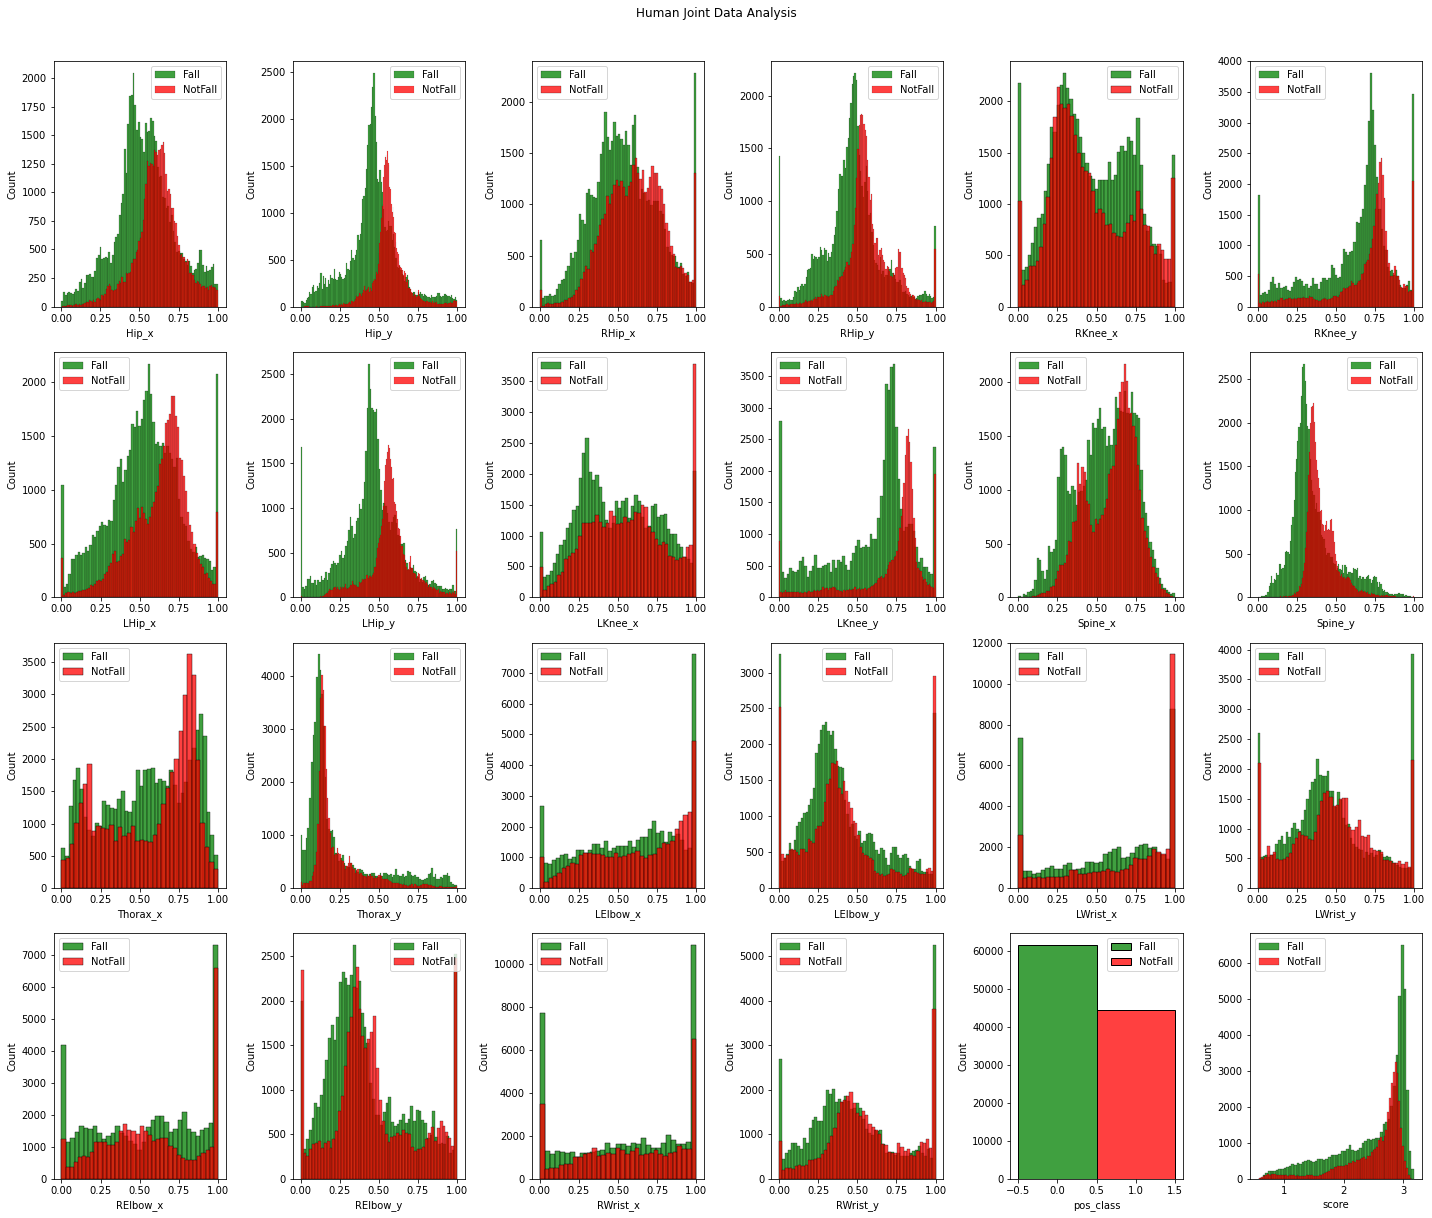

In [44]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in df3.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(df3[i][df3['pos_class']==0], color='g', label = 'Fall')
    sns.histplot(df3[i][df3['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(os.path.dirname(csv_file_path)+'/hist.jpg')
plt.show()

In [45]:
df3

,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,LHip_x,LHip_y,LKnee_x,LKnee_y,...,LElbow_x,LElbow_y,LWrist_x,LWrist_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,pos_class,score
0,0.683773,0.542320,0.766837,0.551426,0.765449,0.767070,0.602313,0.533233,0.709210,0.733625,...,0.240609,0.179022,0.000000,0.209486,0.920420,0.195471,1.0,0.059312,0.0,2.473748
1,0.769453,0.535870,0.846010,0.526362,0.869771,0.740321,0.693623,0.545222,0.824317,0.748223,...,0.216078,0.185140,0.000000,0.188163,0.930376,0.143734,1.0,0.000000,0.0,2.418112
2,0.790536,0.532325,0.806330,0.549650,0.884324,0.750277,0.775145,0.515518,0.961910,0.765468,...,0.803685,0.090439,1.000000,0.000000,0.240442,0.296512,0.0,0.380184,0.0,2.625777
3,0.299634,0.533831,0.384557,0.555062,0.732138,0.773202,0.218065,0.513096,0.789500,0.765931,...,0.254991,0.067931,0.582815,0.000000,0.519928,0.202638,1.0,0.080693,0.0,2.519368
4,0.904549,0.582585,0.990989,0.581077,0.962074,0.765918,0.820142,0.583897,0.957808,0.755543,...,0.185796,0.228912,0.000000,0.272406,0.992829,0.095620,1.0,0.000000,0.0,2.612864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105911,0.467801,0.563755,0.599900,0.589800,0.326467,0.797378,0.334721,0.537717,0.435395,0.695022,...,0.252408,0.296927,0.280644,0.351329,0.895053,0.531157,1.0,0.601242,1.0,2.798440
105912,0.520970,0.586050,0.635176,0.608361,0.318137,0.818399,0.405527,0.563661,0.466687,0.776107,...,0.321983,0.303244,0.279130,0.422085,0.866164,0.529728,1.0,0.600573,1.0,2.808783
105913,0.500961,0.574789,0.619819,0.593548,0.331785,0.806958,0.381062,0.556006,0.457889,0.726885,...,0.317157,0.320912,0.233447,0.426222,0.870148,0.530043,1.0,0.597243,1.0,2.803776
105914,0.508523,0.562977,0.627892,0.586683,0.340410,0.798450,0.387897,0.539206,0.470985,0.732834,...,0.306453,0.277783,0.262816,0.395944,0.881182,0.524324,1.0,0.601011,1.0,2.712823


In [60]:
Fall = df3[df3['pos_class']==0]
NoFall = df3[df3['pos_class']==1]

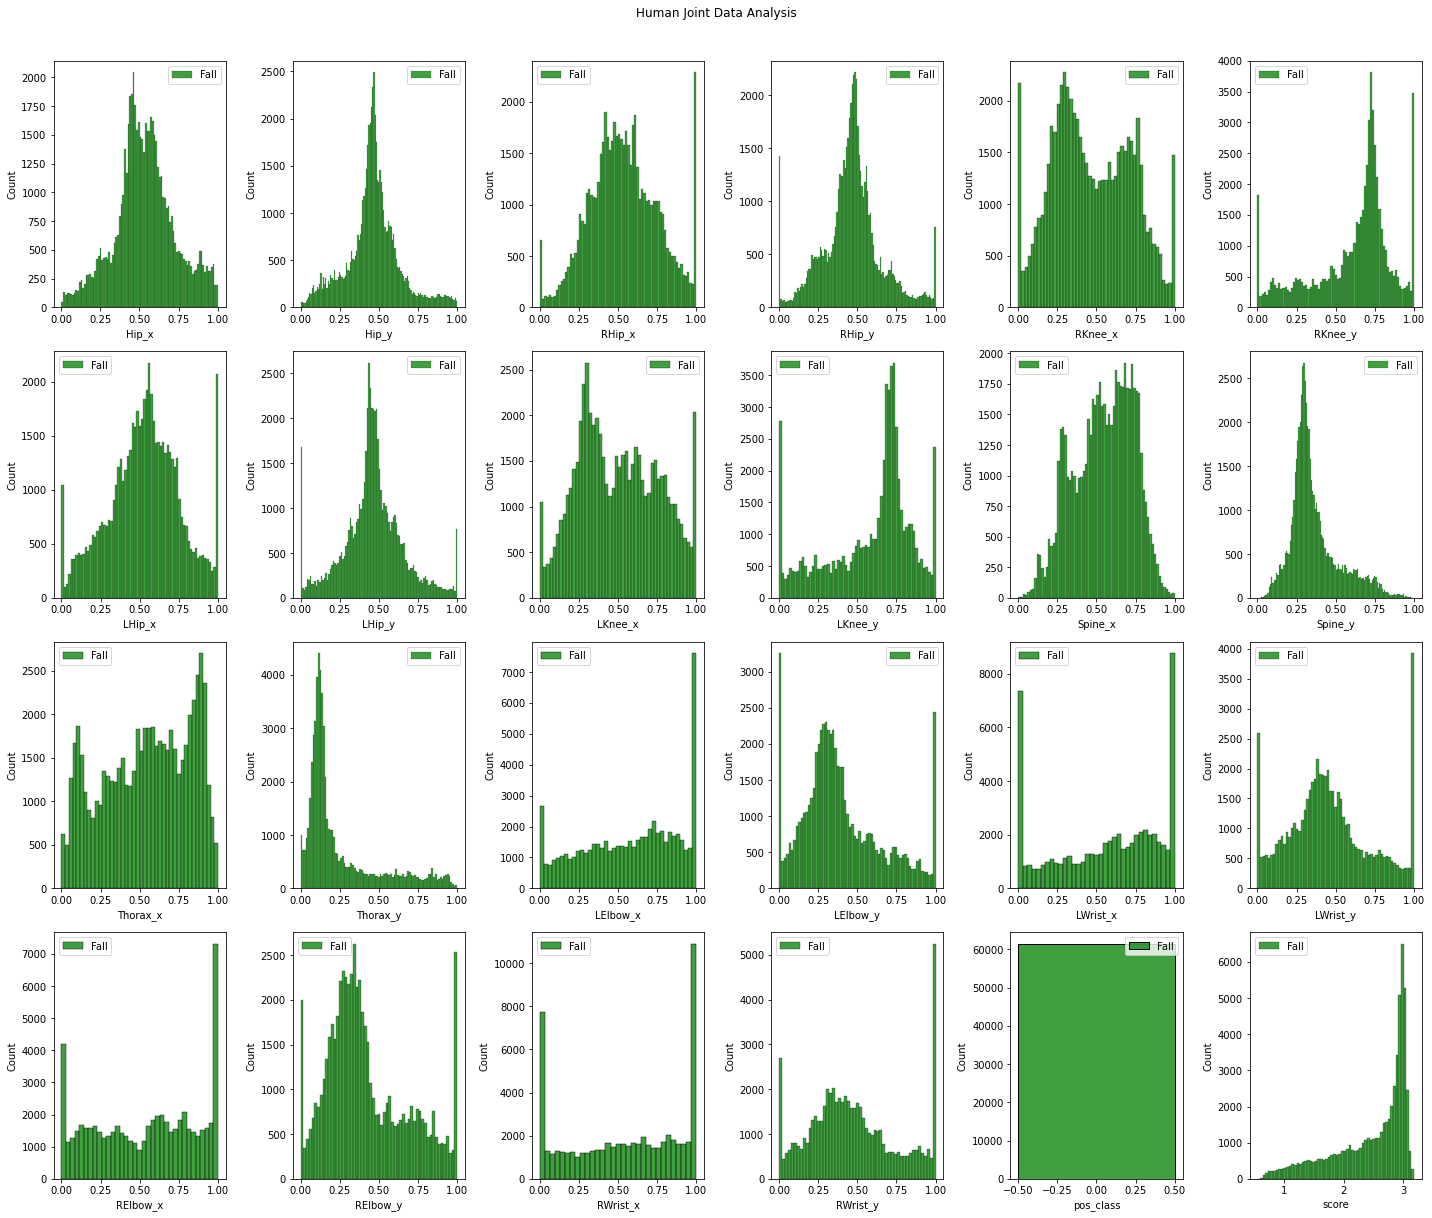

In [62]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in Fall.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(Fall[i], color='g', label = 'Fall')
    #sns.histplot(df3[i][df3['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(os.path.dirname(csv_file_path)+'/hist.jpg')
plt.show()

In [63]:
fall.describe()

,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,LHip_x,LHip_y,LKnee_x,LKnee_y,...,LElbow_x,LElbow_y,LWrist_x,LWrist_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,pos_class,score
count,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,...,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.000000,61451.0,61451.000000
mean,0.534419,0.462809,0.537881,0.465542,0.468916,0.616854,0.530483,0.460556,0.502669,0.590211,...,0.581909,0.397879,0.567368,0.462856,0.538547,0.423281,0.549994,0.480151,0.0,2.467917
std,0.193129,0.171375,0.217447,0.187008,0.252225,0.250469,0.227305,0.194477,0.255960,0.264315,...,0.305097,0.254258,0.336704,0.265939,0.324619,0.259737,0.350579,0.282407,0.0,0.621545
min,0.002493,0.000179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.548282
25%,0.425694,0.386252,0.392487,0.375752,0.273592,0.496091,0.384987,0.365299,0.296679,0.432921,...,0.337201,0.233988,0.286906,0.286749,0.243772,0.242084,0.231019,0.281137,0.0,2.092995
50%,0.526575,0.462711,0.526479,0.468734,0.440799,0.693730,0.538899,0.458170,0.488701,0.681692,...,0.623741,0.343871,0.625917,0.432824,0.577241,0.359391,0.586383,0.440123,0.0,2.727062
75%,0.645349,0.542316,0.683397,0.553256,0.679551,0.762433,0.680906,0.560048,0.712595,0.754519,...,0.844056,0.541347,0.860233,0.614970,0.821719,0.590847,0.880689,0.659399,0.0,2.963448
max,1.000000,0.999851,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,3.183416


In [69]:
Fall2 = fall[fall.score>1.92]

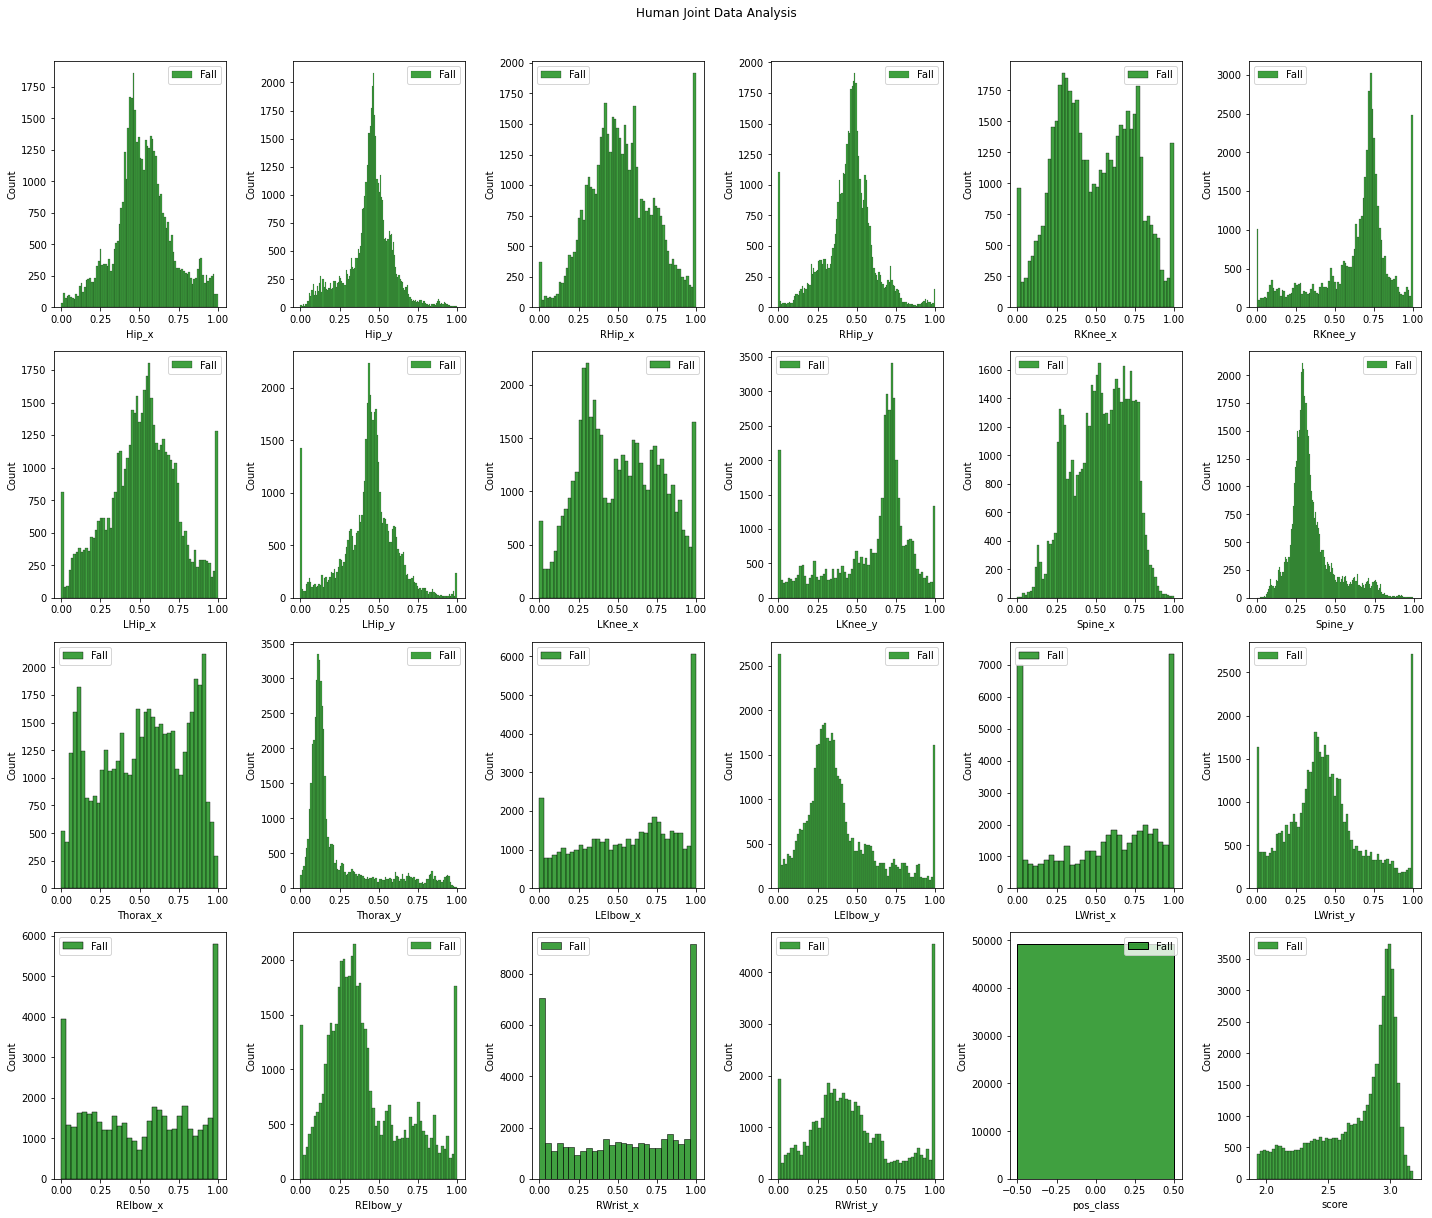

In [70]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in Fall2.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(Fall2[i], color='g', label = 'Fall')
    #sns.histplot(df3[i][df3['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(os.path.dirname(csv_file_path)+'/hist.jpg')
plt.show()

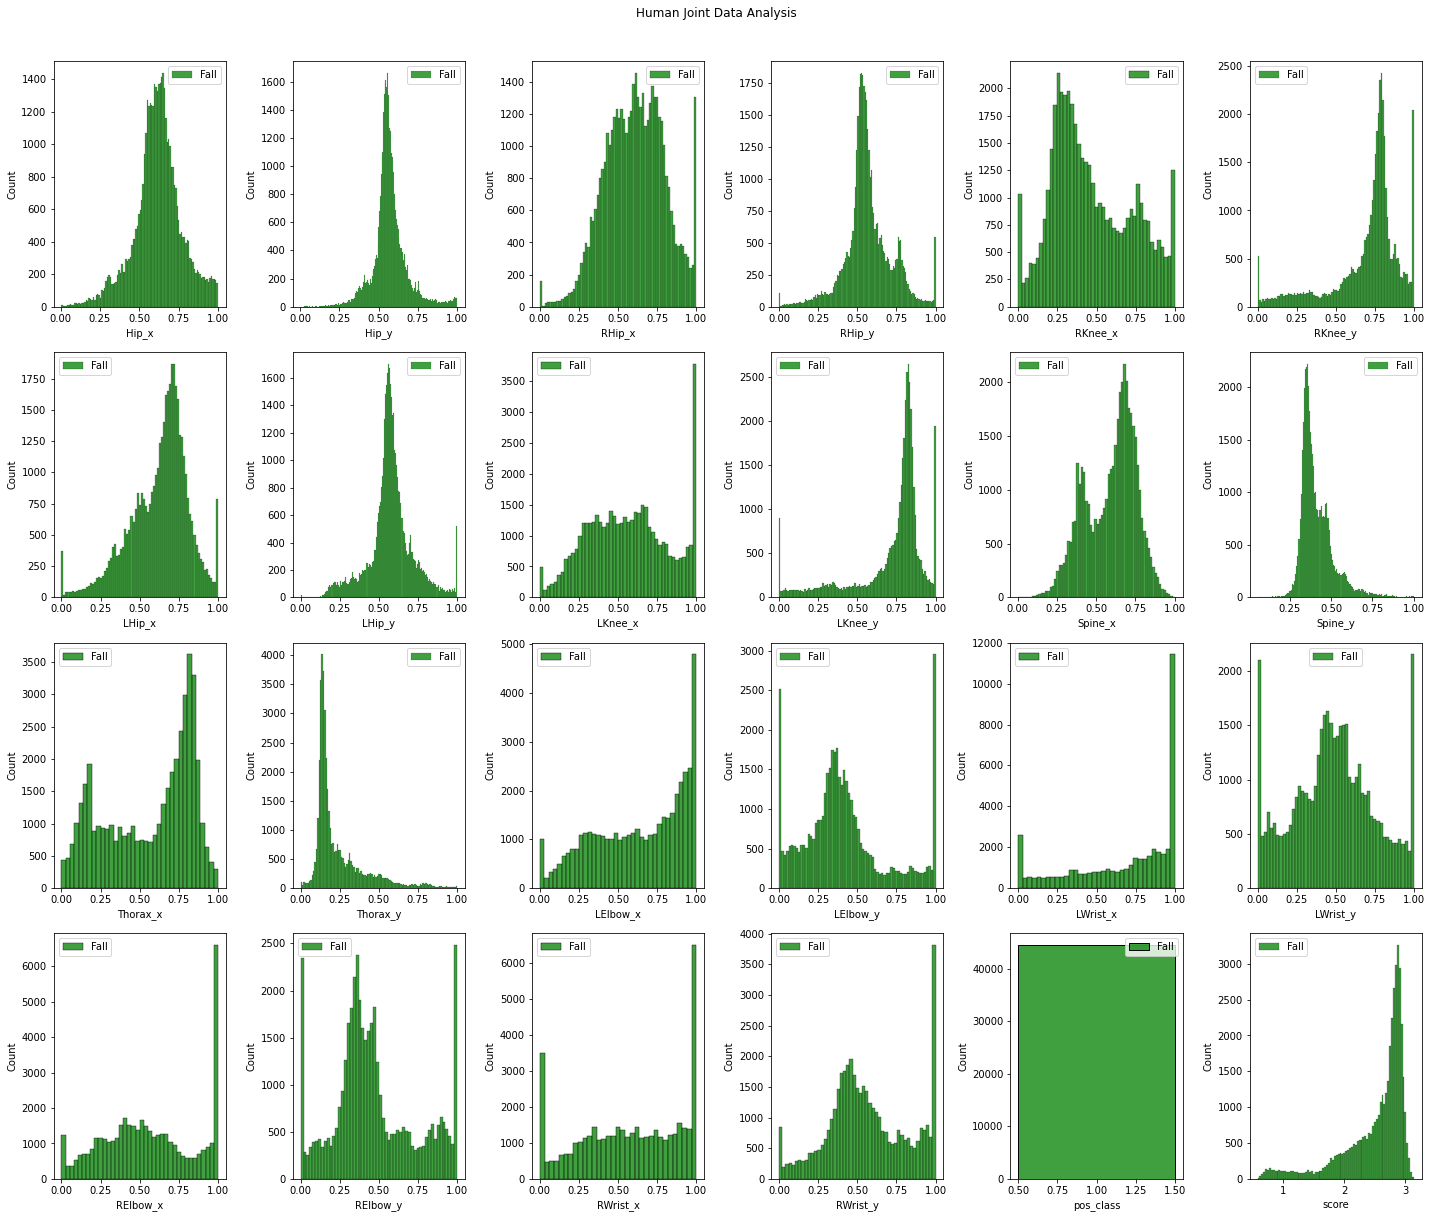

In [71]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in NoFall.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(NoFall[i], color='g', label = 'Fall')
    #sns.histplot(df3[i][df3['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(os.path.dirname(csv_file_path)+'/hist.jpg')
plt.show()

In [72]:
NoFall.describe()

,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,LHip_x,LHip_y,LKnee_x,LKnee_y,...,LElbow_x,LElbow_y,LWrist_x,LWrist_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,pos_class,score
count,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,...,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.000000,44465.0,44465.000000
mean,0.618874,0.570814,0.609612,0.566341,0.467525,0.701184,0.626567,0.575950,0.566989,0.716601,...,0.633055,0.415024,0.676819,0.488320,0.563923,0.469638,0.575134,0.565249,1.0,2.507766
std,0.152016,0.111317,0.189418,0.150029,0.253965,0.218597,0.186748,0.145002,0.258008,0.230334,...,0.288258,0.267862,0.322878,0.264553,0.291985,0.267863,0.318407,0.256026,0.0,0.519545
min,0.004683,0.003214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.581077
25%,0.542776,0.523325,0.475144,0.499766,0.271802,0.645609,0.515643,0.519500,0.364126,0.683416,...,0.392435,0.247682,0.439792,0.304305,0.345257,0.309898,0.326371,0.397442,1.0,2.305532
50%,0.621473,0.560138,0.612656,0.550038,0.411259,0.766439,0.663944,0.571884,0.561262,0.801595,...,0.680123,0.373066,0.783284,0.485803,0.539574,0.418054,0.595476,0.531203,1.0,2.716302
75%,0.703369,0.610346,0.744512,0.638737,0.674231,0.816294,0.747567,0.636355,0.758235,0.842324,...,0.898479,0.516259,0.975706,0.661419,0.818947,0.639853,0.871915,0.765464,1.0,2.865008
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,3.140766


In [74]:
NoFall2 = NoFall[NoFall.score>1.98]

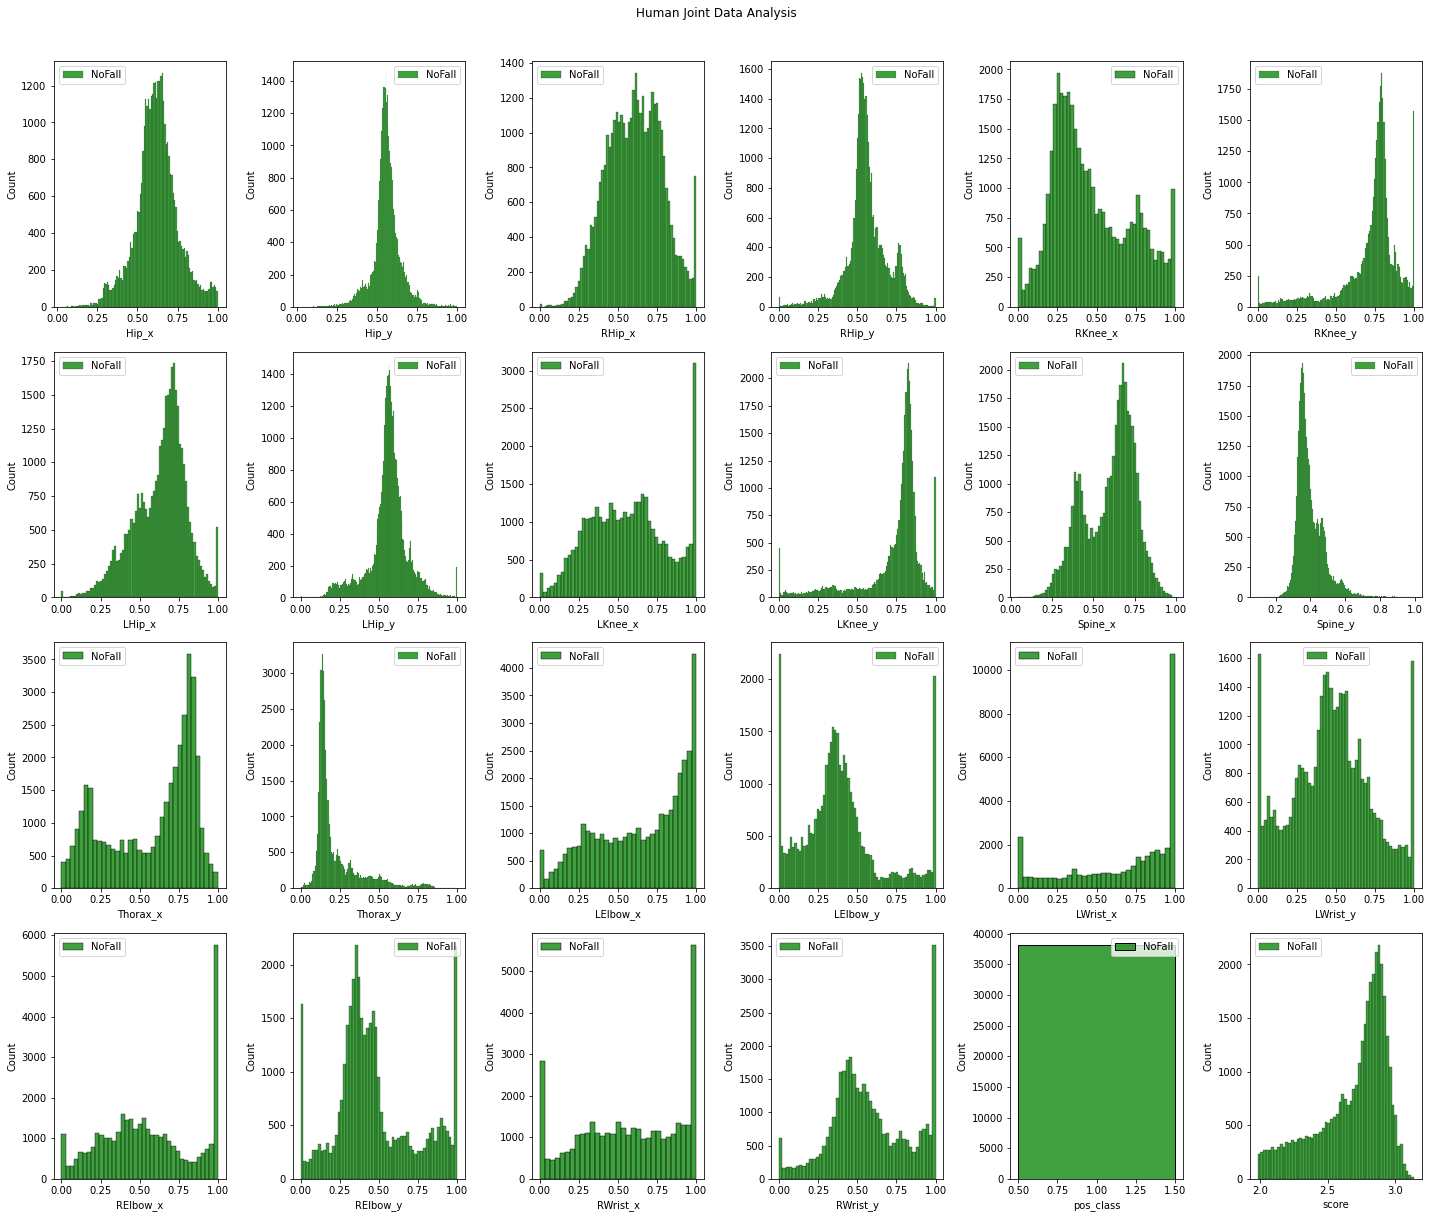

In [75]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in NoFall2.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(NoFall2[i], color='g', label = 'NoFall')
    #sns.histplot(df3[i][df3['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(os.path.dirname(csv_file_path)+'/hist.jpg')
plt.show()

In [76]:
df_new = pd.concat([Fall,NoFall])

In [78]:
df_new.head()

,Hip_x,Hip_y,RHip_x,RHip_y,RKnee_x,RKnee_y,LHip_x,LHip_y,LKnee_x,LKnee_y,...,LElbow_x,LElbow_y,LWrist_x,LWrist_y,RElbow_x,RElbow_y,RWrist_x,RWrist_y,pos_class,score
0,0.683773,0.542320,0.766837,0.551426,0.765449,0.767070,0.602313,0.533233,0.709210,0.733625,...,0.240609,0.179022,0.000000,0.209486,0.920420,0.195471,1.0,0.059312,0.0,2.473748
1,0.769453,0.535870,0.846010,0.526362,0.869771,0.740321,0.693623,0.545222,0.824317,0.748223,...,0.216078,0.185140,0.000000,0.188163,0.930376,0.143734,1.0,0.000000,0.0,2.418112
2,0.790536,0.532325,0.806330,0.549650,0.884324,0.750277,0.775145,0.515518,0.961910,0.765468,...,0.803685,0.090439,1.000000,0.000000,0.240442,0.296512,0.0,0.380184,0.0,2.625777
3,0.299634,0.533831,0.384557,0.555062,0.732138,0.773202,0.218065,0.513096,0.789500,0.765931,...,0.254991,0.067931,0.582815,0.000000,0.519928,0.202638,1.0,0.080693,0.0,2.519368
4,0.904549,0.582585,0.990989,0.581077,0.962074,0.765918,0.820142,0.583897,0.957808,0.755543,...,0.185796,0.228912,0.000000,0.272406,0.992829,0.095620,1.0,0.000000,0.0,2.612864


In [79]:
corr2_matrix = df_new.corr()

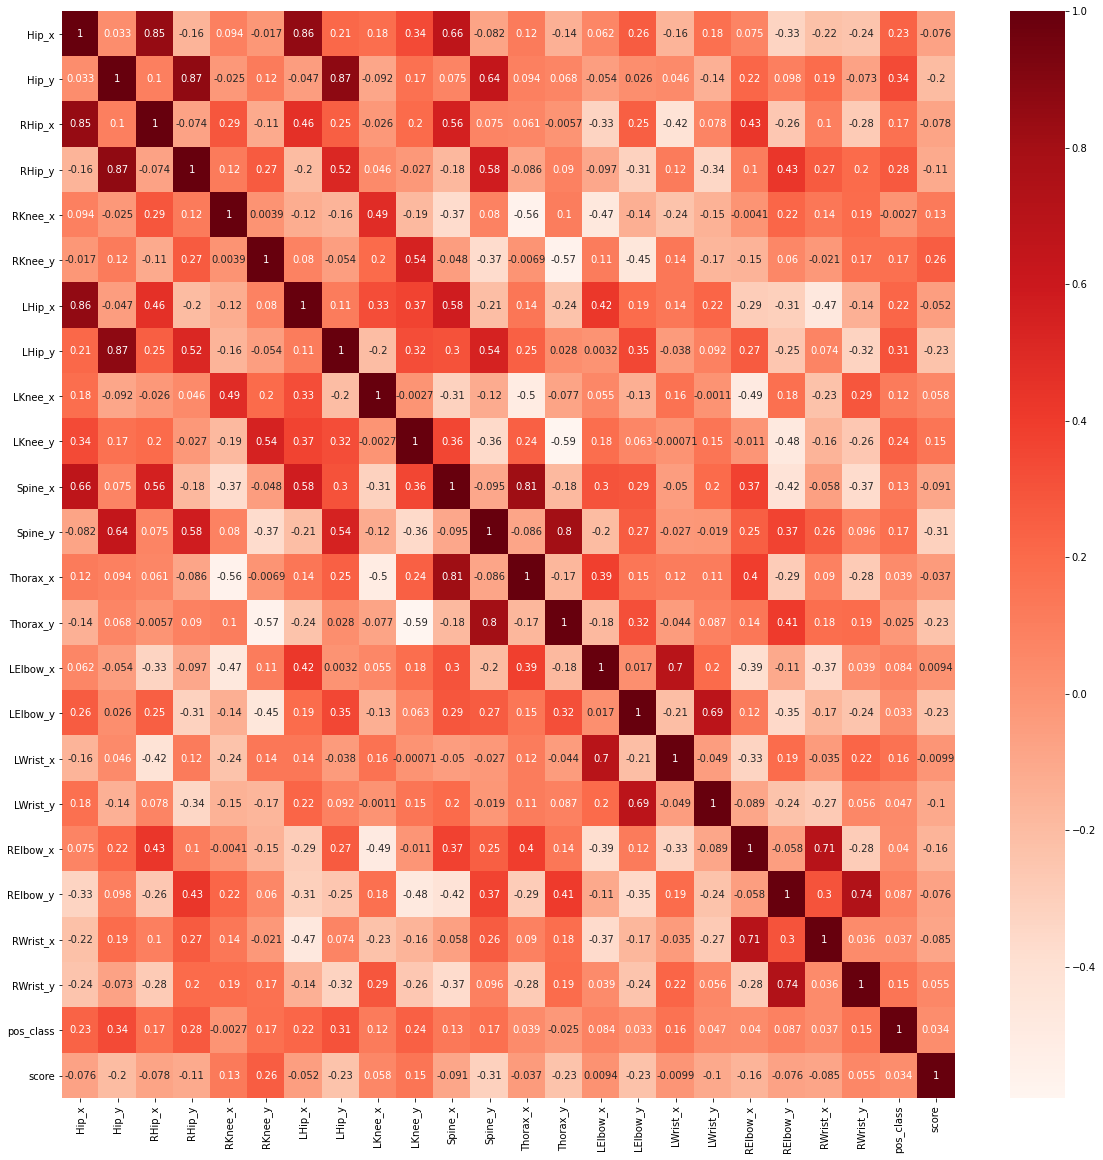

In [80]:
fig = plt.figure(figsize = (20, 20))
_=sns.heatmap(corr2_matrix,annot=True, cmap=plt.cm.Reds)
plt.savefig(os.path.dirname(csv_file_path)+'/pearson_corr.jpg')

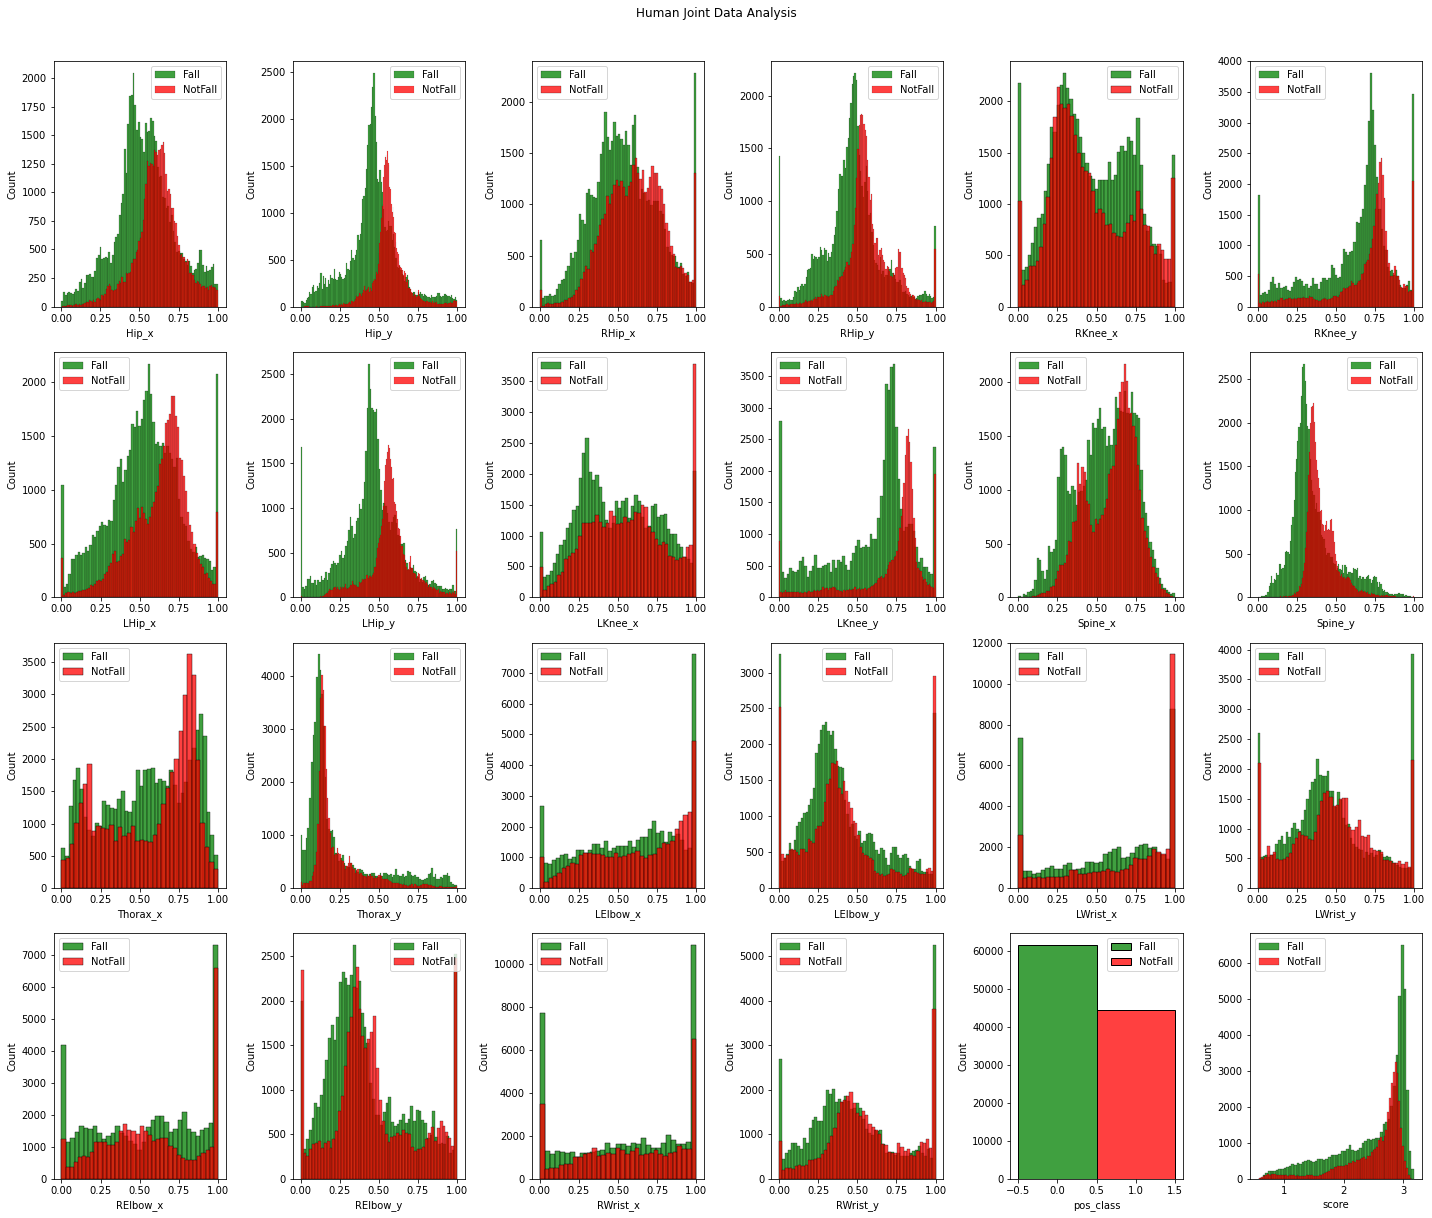

In [81]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in df3.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(df_new[i][df_new['pos_class']==0], color='g', label = 'Fall')
    sns.histplot(df_new[i][df_new['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(os.path.dirname(csv_file_path)+'/hist.jpg')
plt.show()

In [84]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105916 entries, 0 to 105915
Data columns (total 24 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Hip_x      105916 non-null  float64
 1   Hip_y      105916 non-null  float64
 2   RHip_x     105916 non-null  float64
 3   RHip_y     105916 non-null  float64
 4   RKnee_x    105916 non-null  float64
 5   RKnee_y    105916 non-null  float64
 6   LHip_x     105916 non-null  float64
 7   LHip_y     105916 non-null  float64
 8   LKnee_x    105916 non-null  float64
 9   LKnee_y    105916 non-null  float64
 10  Spine_x    105916 non-null  float64
 11  Spine_y    105916 non-null  float64
 12  Thorax_x   105916 non-null  float64
 13  Thorax_y   105916 non-null  float64
 14  LElbow_x   105916 non-null  float64
 15  LElbow_y   105916 non-null  float64
 16  LWrist_x   105916 non-null  float64
 17  LWrist_y   105916 non-null  float64
 18  RElbow_x   105916 non-null  float64
 19  RElbow_y   105916 non-n

In [88]:
df_new.columns

Index(['Hip_x', 'Hip_y', 'RHip_x', 'RHip_y', 'RKnee_x', 'RKnee_y', 'LHip_x',
       'LHip_y', 'LKnee_x', 'LKnee_y', 'Spine_x', 'Spine_y', 'Thorax_x',
       'Thorax_y', 'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y', 'RElbow_x',
       'RElbow_y', 'RWrist_x', 'RWrist_y', 'pos_class', 'score'],
      dtype='object')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1e3e9c710>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1e4230278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1e41d1160>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1e4229390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1e4229438>],
 'means': []}

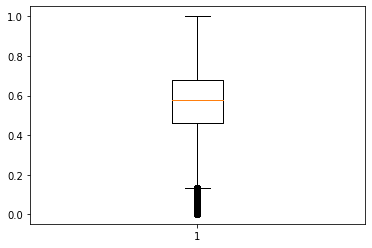

In [94]:
import seaborn as sns
plt.boxplot(df_new['Hip_x'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1e1f41048>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1e4dcdba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1e1f15748>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1e4dcdbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1e4dcd2e8>],
 'means': []}

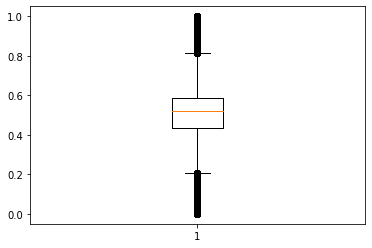

In [95]:
plt.boxplot(df_new['Hip_y'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1e3f53278>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1e3f65470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1e3f53c50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1e3f65a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1e3f65cf8>],
 'means': []}

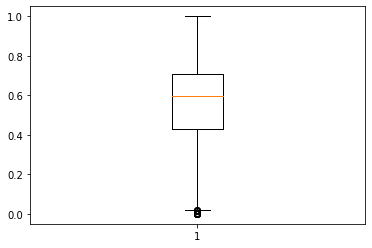

In [96]:
plt.boxplot(df_new['Spine_x'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1e313f4a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1e683d080>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1e33acf98>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1e2189278>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1e30e4668>],
 'means': []}

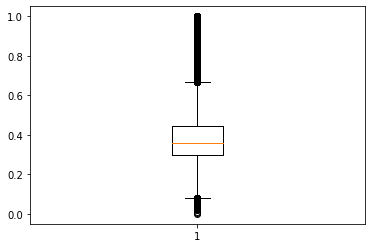

In [97]:
plt.boxplot(df_new['Spine_y'])

<AxesSubplot:title={'center':'Hip_y'}, xlabel='pos_class'>

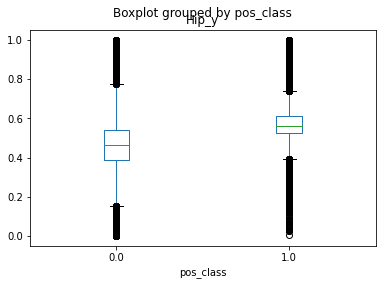

In [100]:
df_new.boxplot(by ='pos_class', column =['Hip_y'], grid = False)

<AxesSubplot:title={'center':'Hip_x'}, xlabel='pos_class'>

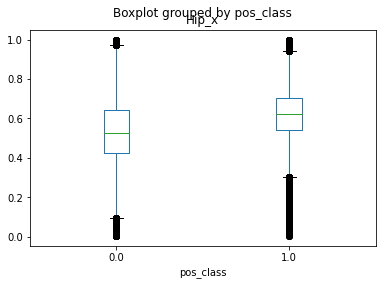

In [101]:
df_new.boxplot(by ='pos_class', column =['Hip_x'], grid = False)

<AxesSubplot:title={'center':'Spine_x'}, xlabel='pos_class'>

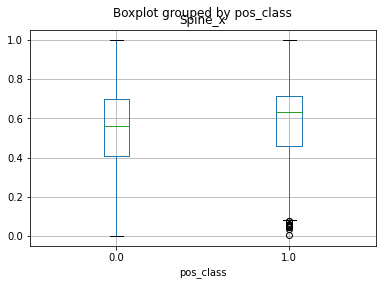

In [102]:
df_new.boxplot(by ='pos_class', column =['Spine_x'], grid = True)

<AxesSubplot:title={'center':'Spine_y'}, xlabel='pos_class'>

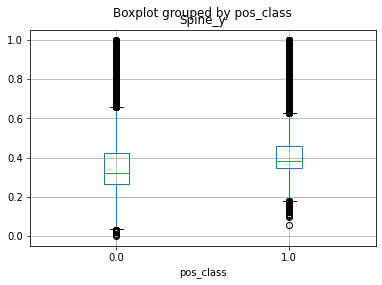

In [103]:
df_new.boxplot(by ='pos_class', column =['Spine_y'], grid = True)

In [112]:
dfn = df_new[(df_new.Hip_y>0.15) & (df_new.Spine_y<0.7)]

In [113]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98442 entries, 0 to 105915
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hip_x      98442 non-null  float64
 1   Hip_y      98442 non-null  float64
 2   RHip_x     98442 non-null  float64
 3   RHip_y     98442 non-null  float64
 4   RKnee_x    98442 non-null  float64
 5   RKnee_y    98442 non-null  float64
 6   LHip_x     98442 non-null  float64
 7   LHip_y     98442 non-null  float64
 8   LKnee_x    98442 non-null  float64
 9   LKnee_y    98442 non-null  float64
 10  Spine_x    98442 non-null  float64
 11  Spine_y    98442 non-null  float64
 12  Thorax_x   98442 non-null  float64
 13  Thorax_y   98442 non-null  float64
 14  LElbow_x   98442 non-null  float64
 15  LElbow_y   98442 non-null  float64
 16  LWrist_x   98442 non-null  float64
 17  LWrist_y   98442 non-null  float64
 18  RElbow_x   98442 non-null  float64
 19  RElbow_y   98442 non-null  float64
 20  RWris

In [ ]:
['Hip_x','Hip_y','RHip_x','RHip_y','RKnee_x','RKnee_y','LHip_x',
'LHip_y','LKnee_x','LKnee_y','Spine_x','Spine_y','Thorax_x',
'Thorax_y','LElbow_x','LElbow_y','LWrist_x','LWrist_y','RElbow_x',
'RElbow_y','RWrist_x','RWrist_y']

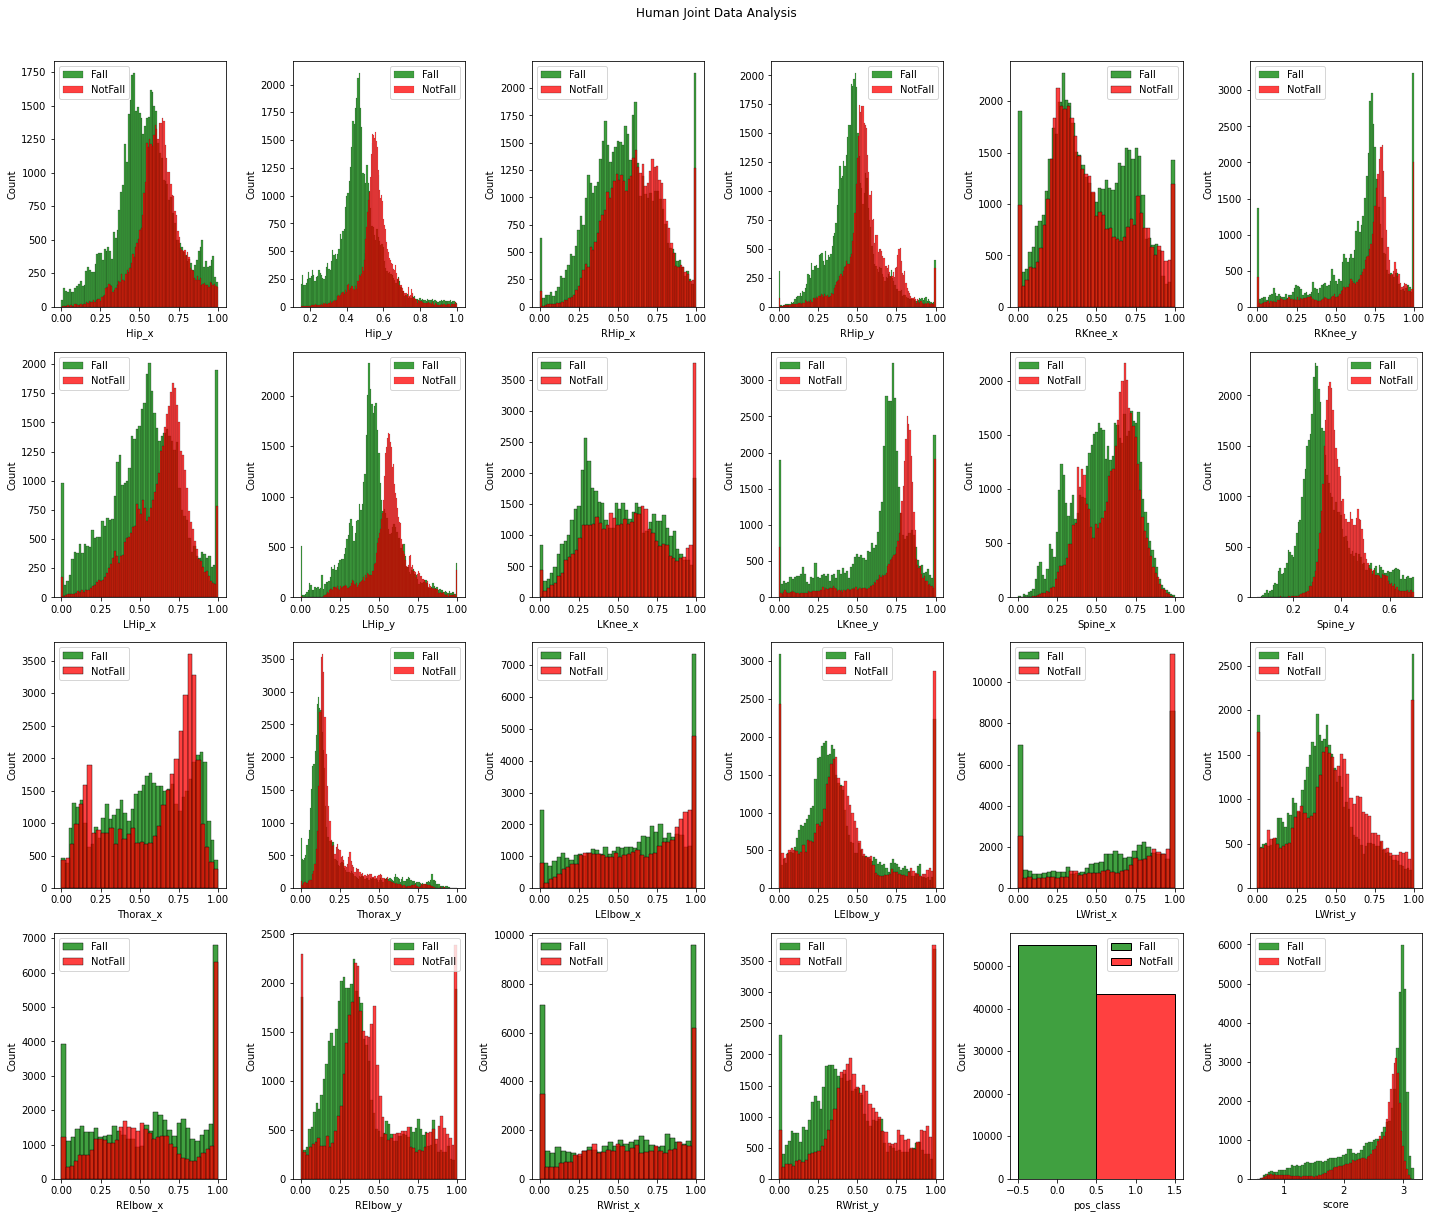

In [114]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in dfn.columns:
    _=plt.subplot(6, 6, j+1)
    j += 1
    sns.histplot(dfn[i][dfn['pos_class']==0], color='g', label = 'Fall')
    sns.histplot(dfn[i][dfn['pos_class']==1], color='r', label = 'NotFall')
    plt.legend(loc='best')
fig.suptitle('Human Joint Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(os.path.dirname(csv_file_path)+'/histfinal.jpg')
plt.show()

In [115]:
dfn.pos_class.value_counts()

0.0    54983
1.0    43459
Name: pos_class, dtype: int64

In [116]:
dfn.to_csv(csv_file_path)